**Predicting Breast Cancer From Nuclear Shape**

**The nucleus is an organelle present within all eukaryotic cells, including human cells.  Abberant nuclear shape can be used to identify cancer cells (e.g. pap smear tests and the diagnosis of cervical cancer).  Likewise, a growing body of literature suggests that there is some connection between the shape of the nucleus and human disease states such as cancer and aging. As such, the quantitative analysis of nuclear size and shape has important biomedical applications.**

Technicians can use a microscope to observe tissue samples that were taken from patients who are suspected to have breast cancer.  By looking at the size and shape of the nuclei present within these tissue samples, doctors can determine whether a given sample appears to be benign ("B") or malignant ("M").  It would be hepful to have an automated method that can quickly determine if a sample is benign or malignant.  Here in this document I demonstrate a methodology to predict if a sample is benign or malignant given measurements of nuclear shape that were made from digital images of fine needle aspirates of breast tissue masses from clinical samples.

For more information about the relationship between nuclear shape and human disease, please refer to the following resources: 
* Zink, D., Fischer, A.H., and Nickerson, J.A. (2004). Nuclear structure in cancer cells. Nat. Rev. Cancer 4, 677–687.  https://www.ncbi.nlm.nih.gov/pubmed/15343274
* Webster, M., Witkin, K.L., and Cohen-Fix, O. (2009). Sizing up the nucleus: nuclear shape, size and nuclear-envelope assembly. J. Cell Sci. 122, 1477–1486.  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2680097/
* Vukovic LD, Jevtic P, Edens LJ, Levy DL. (2016) New Insights into Mechanisms and Functions of Nuclear Size Regulation. Int Rev Cell Mol Biol. 322:1–59.  https://www.ncbi.nlm.nih.gov/pubmed/26940517
* http://www.uwyo.edu/levy_lab/

**This script takes as an input a CSV file containing quantitative measurements of nuclear size and nuclear shape.  These measurements were taken from digital images of fine needle aspirates taken from clinical samples. The output of this script is a prediction of whether a given patient has a tumor that is benign ("B") or malignant ("M").**

Webster, M., Witkin, K.L., and Cohen-Fix, O. (2009). Sizing up the nucleus: nuclear shape, size and nuclear-envelope assembly. J. Cell Sci. 122, 1477–1486.


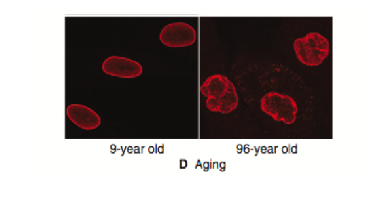

In [1]:
import cv2
import matplotlib.pyplot as plt
PNG_location = "/kaggle/input/webster-2009/webster 2009.png"
def plotPNG(a):
    """
    Plot a PNG Image w/ Matplotlib
    """
    PNG = cv2.imread(PNG_location)
    PNG = cv2.resize(PNG, (512,256))
    plt.imshow(cv2.cvtColor(PNG, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotPNG(PNG_location)
print("Webster, M., Witkin, K.L., and Cohen-Fix, O. (2009). Sizing up the nucleus: nuclear shape, size and nuclear-envelope assembly. J. Cell Sci. 122, 1477–1486.")

*Step 1: Import Modules*

In [2]:
#from __future__ import print_function
#import os
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score 
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier as MLPC
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
%matplotlib inline

Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


*Step 2: Explore Data - See Column Titles, Raw Data, and Null Counts*

In [3]:
sizeMeasurements = pd.read_csv('../input/breast-cancer-wisconsin-data/data.csv')
def describeData(a):
    """ 
    Print column titles, first few values, and null value counts
    """  
    print('\n Column Values: \n\n', a.columns.values, "\n")
    print('\n First Few Values: \n\n', a.head(), "\n")
    print('\n Null Value Counts: \n\n', a.isnull().sum(), "\n")
describeData(sizeMeasurements)


 Column Values: 

 ['id' 'diagnosis' 'radius_mean' 'texture_mean' 'perimeter_mean' 'area_mean'
 'smoothness_mean' 'compactness_mean' 'concavity_mean'
 'concave points_mean' 'symmetry_mean' 'fractal_dimension_mean' 'radius_se'
 'texture_se' 'perimeter_se' 'area_se' 'smoothness_se' 'compactness_se'
 'concavity_se' 'concave points_se' 'symmetry_se' 'fractal_dimension_se'
 'radius_worst' 'texture_worst' 'perimeter_worst' 'area_worst'
 'smoothness_worst' 'compactness_worst' 'concavity_worst'
 'concave points_worst' 'symmetry_worst' 'fractal_dimension_worst'
 'Unnamed: 32'] 


 First Few Values: 

          id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  8

*Step 3: Plot Data - Compare the size and shape of the nuclei from malignant samples to the size and shape of the nuclei from benign samples.*

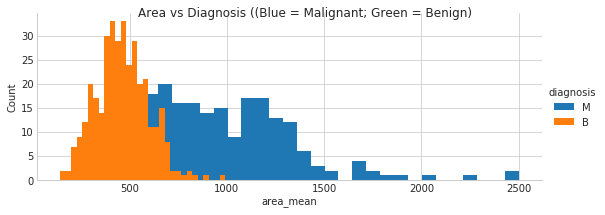

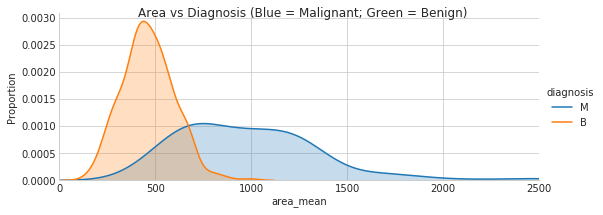

In [4]:
def plotSizeDistribution(a):
    """ 
    Plot size distribution for benign vs malignant samples
    """  
    sns.set_style("whitegrid")
    distributionOne = sns.FacetGrid(a, hue="diagnosis",aspect=2.5)
    distributionOne.map(plt.hist, 'area_mean', bins=30)
    distributionOne.add_legend()
    distributionOne.set_axis_labels('area_mean', 'Count')
    distributionOne.fig.suptitle('Area vs Diagnosis ((Blue = Malignant; Green = Benign)')
    distributionTwo = sns.FacetGrid(a, hue="diagnosis",aspect=2.5)
    distributionTwo.map(sns.kdeplot,'area_mean',shade=True)
    distributionTwo.set(xlim=(0, a['area_mean'].max()))
    distributionTwo.add_legend()
    distributionTwo.set_axis_labels('area_mean', 'Proportion')
    distributionTwo.fig.suptitle('Area vs Diagnosis (Blue = Malignant; Green = Benign)')
plotSizeDistribution(sizeMeasurements)

This confirms my prediction that healthy nuclei have a default size and that cancer cells have a wide range of sizes, typically greater than the default size.

In addition to being larger than healthy cells, cancer cells are often mishapen.

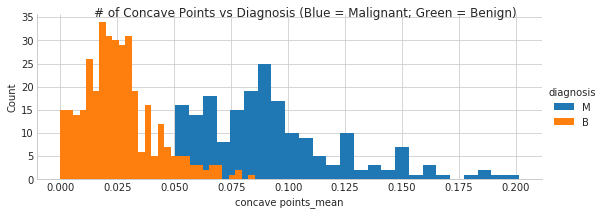

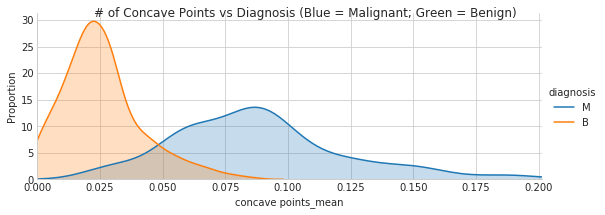

In [5]:
def plotConcaveDistribution(a):
    """ 
    Plot shape distribution for benign vs malignant samples
    """  
    sns.set_style("whitegrid")
    distributionOne = sns.FacetGrid(a, hue="diagnosis",aspect=2.5)
    distributionOne.map(plt.hist, 'concave points_mean', bins=30)
    distributionOne.add_legend()
    distributionOne.set_axis_labels('concave points_mean', 'Count')
    distributionOne.fig.suptitle('# of Concave Points vs Diagnosis (Blue = Malignant; Green = Benign)')
    distributionTwo = sns.FacetGrid(a, hue="diagnosis",aspect=2.5)
    distributionTwo.map(sns.kdeplot,'concave points_mean',shade= True)
    distributionTwo.set(xlim=(0, a['concave points_mean'].max()))
    distributionTwo.add_legend()
    distributionTwo.set_axis_labels('concave points_mean', 'Proportion')
    distributionTwo.fig.suptitle('# of Concave Points vs Diagnosis (Blue = Malignant; Green = Benign)')
plotConcaveDistribution(sizeMeasurements)

This confirms my prediction that healthy nuclei are typically circular/elliptical and that cancer cells are mishapen and have lots of concave points.

*Step 4: Preprocess Data*

Next I will pre-process the data so that it is ready for analysis.  First I will convert the labels "B" and "M" to 0 and 1, respectively.
Next I will scale the values by using the sklearn.preprocessing.scale function which functions by subtracting the mean and then dividing by the standard deviation in order to generate values that are centered around zero.  You can learn more about the sklearn.preprocessing.scale function at the following link: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html 

By doing this we will have data with numerical Y values and X values that are centered around zero.  This type of data is compatible with a wide variety of different classification algorithms.


In [6]:
def diagnosisToBinary(a):
    """ 
    convert diagnosis to binary label
    """ 
    a["diagnosis"] = a["diagnosis"].astype("category")
    a["diagnosis"].cat.categories = [0,1]
    a["diagnosis"] = a["diagnosis"].astype("int")
diagnosisToBinary(sizeMeasurements)

xValues = sizeMeasurements.drop(['diagnosis', 'Unnamed: 32', 'id'], axis=1)
yValues = sizeMeasurements['diagnosis']
xValuesScaled = preprocessing.scale(xValues)
xValuesScaled = pd.DataFrame(xValuesScaled, columns = xValues.columns)

Another data preprocessing step that we can do is Principal Component Analysis (PCA).  With PCA we transform our features to make them less correlated  via a process that involves dimensionality reduction.  For more information, see the following documentaion: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html, http://scikit-learn.org/stable/modules/decomposition.html#pca

Furthermore, we will also need to split up our training data, setting aside 20% of the training data for cross-validation testing, such that we can avoid potentially overfitting the data.  The train_test_split function accomplishes this, as described in the following documentation:
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation



In [7]:
variance_pct = .99 # Minimum percentage of variance we want to be described by the resulting transformed components
pca = PCA(n_components=variance_pct) # Create PCA object
X_transformed = pca.fit_transform(xValuesScaled,yValues) # Transform the initial features
xValuesScaledPCA = pd.DataFrame(X_transformed) # Create a data frame from the PCA'd data

X_trainOriginal, X_testOriginal, Y_trainOriginal, Y_testOriginal = train_test_split(xValues, yValues, test_size=0.2)
X_trainScaled, X_testScaled, Y_trainScaled, Y_testScaled = train_test_split(xValuesScaled, yValues, test_size=0.2)
X_trainScaledPCA, X_testScaledPCA, Y_trainScaledPCA, Y_testScaledPCA = train_test_split(xValuesScaledPCA, yValues, test_size=0.2)


Feature Correlation Before PCA:



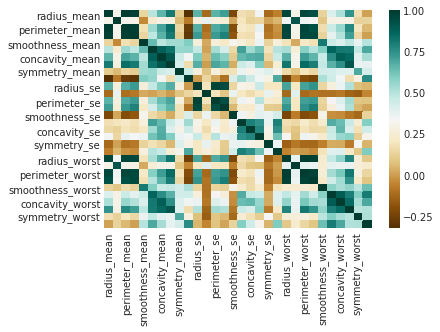

In [8]:
print("\nFeature Correlation Before PCA:\n")
g = sns.heatmap(X_trainOriginal.corr(),cmap="BrBG",annot=False)


Feature Correlation After PCA:



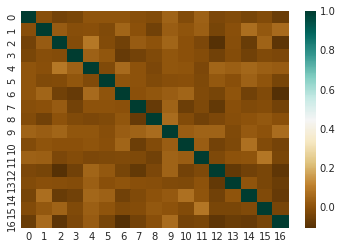

In [9]:
print("\nFeature Correlation After PCA:\n")
i = sns.heatmap(X_trainScaledPCA.corr(),cmap="BrBG",annot=False)

In [10]:
print('\n First Few Values, Original: \n\n', xValues.head(), "\n\n")
print('First Few Values, Scaled: \n\n,',xValuesScaled.head(),'\n\n')
print('First Few Values, After PCA: \n\n,',xValuesScaledPCA.head(),'\n\n')


 First Few Values, Original: 

    radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   fractal_dimension_mean           ...             radius_

*Step 5: Define Helper Functions - for Plotting Learning Curve and Confusion Matrix*

In [11]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Plots a learning curve. http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

dict_characters = {0: 'Malignant', 1: 'Benign'}



*Step 6: Evaluate Classification Models*

Now I will try running a few different classification algorithms such as Logistic Regression and Support Vector Machines.  I will do this both with and without the data scaling step in order to illustrate the importance of this preprocessing step.

Before Data Scaling:

Compare Multiple Classifiers: 

K-Fold Cross-Validation Accuracy: 

LR: 0.902273 (0.125193)
RF: 0.929545 (0.084091)
KNN: 0.903788 (0.060040)
SVM: 0.659091 (0.084496)
LSVM: 0.841667 (0.104724)
GNB: 0.921970 (0.094987)
DTC: 0.884848 (0.043756)
GBC: 0.885606 (0.078251)


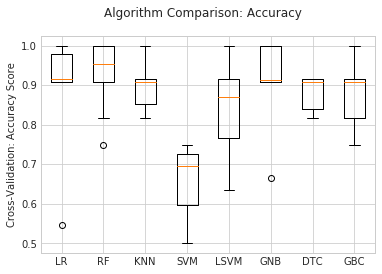

After Data Scaling:

Compare Multiple Classifiers: 

K-Fold Cross-Validation Accuracy: 

LR: 0.973485 (0.040550)
RF: 0.965152 (0.042748)
KNN: 0.965152 (0.042748)
SVM: 0.965152 (0.042748)
LSVM: 0.955303 (0.060459)
GNB: 0.937879 (0.057576)
DTC: 0.938636 (0.054886)
GBC: 0.947727 (0.056737)


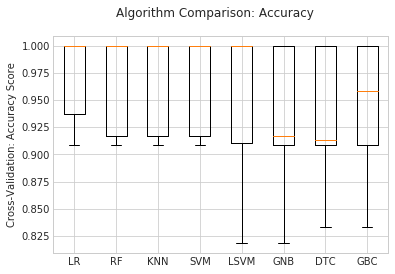

After PCA:

Compare Multiple Classifiers: 

K-Fold Cross-Validation Accuracy: 

LR: 0.956818 (0.043261)
RF: 0.913636 (0.088035)
KNN: 0.905303 (0.080049)
SVM: 0.931061 (0.083776)
LSVM: 0.938636 (0.057241)
GNB: 0.818182 (0.133772)
DTC: 0.885606 (0.091127)
GBC: 0.894697 (0.120140)


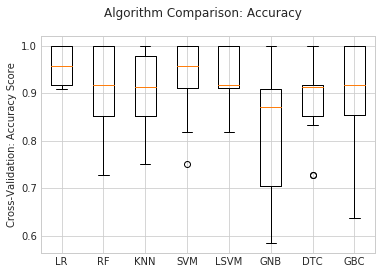


LR = LogisticRegression
RF = RandomForestClassifier
KNN = KNeighborsClassifier
SVM = Support Vector Machine SVC
LSVM = LinearSVC
GNB = GaussianNB
DTC = DecisionTreeClassifier
GBC = GradientBoostingClassifier 




In [12]:
def compareABunchOfDifferentModelsAccuracy(a, b, c, d):
    """
    compare performance of classifiers on X_train, X_test, Y_train, Y_test
    http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
    http://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score
    """    
    print('\nCompare Multiple Classifiers: \n')
    print('K-Fold Cross-Validation Accuracy: \n')
    names = []
    models = []
    resultsAccuracy = []
    models.append(('LR', LogisticRegression()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('SVM', SVC()))
    models.append(('LSVM', LinearSVC()))
    models.append(('GNB', GaussianNB()))
    models.append(('DTC', DecisionTreeClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    #models.append(('LDA', LinearDiscriminantAnalysis()))
    for name, model in models:
        model.fit(a, b)
        kfold = model_selection.KFold(n_splits=10, random_state=7)
        accuracy_results = model_selection.cross_val_score(model, c, d, cv=kfold, scoring='accuracy')
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage) 
    # Boxplot
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: Accuracy')
    ax = fig.add_subplot(111)
    plt.boxplot(resultsAccuracy)
    ax.set_xticklabels(names)
    ax.set_ylabel('Cross-Validation: Accuracy Score')
    plt.show()

print("Before Data Scaling:")
compareABunchOfDifferentModelsAccuracy(X_trainOriginal, Y_trainOriginal, X_testOriginal, Y_testOriginal)
print("After Data Scaling:")
compareABunchOfDifferentModelsAccuracy(X_trainScaled, Y_trainScaled, X_testScaled, Y_testScaled)
print("After PCA:")
compareABunchOfDifferentModelsAccuracy(X_trainScaledPCA, Y_trainScaledPCA, X_testScaledPCA, Y_testScaledPCA)

def defineModels():
    """
    This function just defines each abbreviation used in the previous function (e.g. LR = Logistic Regression)
    """
    print('\nLR = LogisticRegression')
    print('RF = RandomForestClassifier')
    print('KNN = KNeighborsClassifier')
    print('SVM = Support Vector Machine SVC')
    print('LSVM = LinearSVC')
    print('GNB = GaussianNB')
    print('DTC = DecisionTreeClassifier')
    print('GBC = GradientBoostingClassifier \n\n')
    #print('LDA = LinearDiscriminantAnalysis')
defineModels()

In order to choose between these classification algorithms, I will plot learning curves where I illustrate the relationship between the accuracy score and the cross validation score for increasing sample sizes.  I will do this to make sure that we are not overfitting the training data (despite setting aside 20% of the data for cross-validation testing).  If there is too big of a gap between the two curves the model likely has high bias.  If there is too little of a gap between the two curves the model likely is overfit.  We want a learning curve where the cross-validation score gets close to converging with the training score but does not quite converge. 

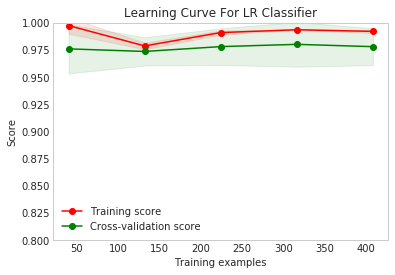

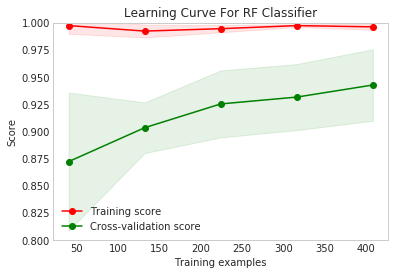

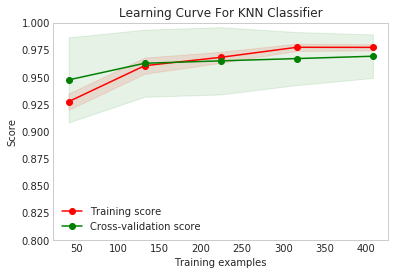

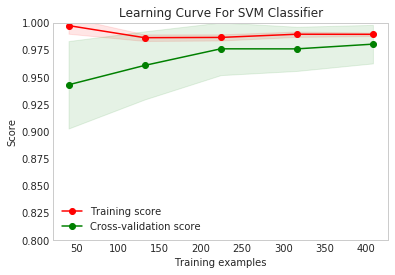

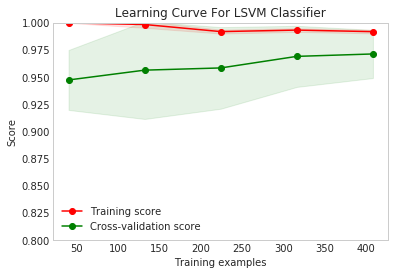

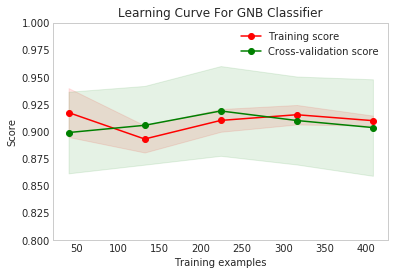

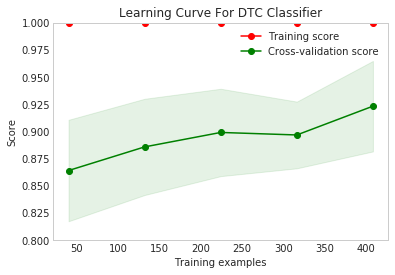

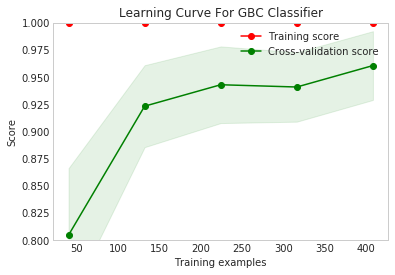

In [13]:
def plotLotsOfLearningCurves(a,b):
    """Now let's plot a bunch of learning curves
    # http://scikit-learn.org/stable/modules/learning_curve.html
    """
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('SVM', SVC()))
    models.append(('LSVM', LinearSVC()))
    models.append(('GNB', GaussianNB()))
    models.append(('DTC', DecisionTreeClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    #models.append(('LDA', LinearDiscriminantAnalysis()))
    #models.append(('MLP', MLPC()))
    for name, model in models:
        plot_learning_curve(model, 'Learning Curve For %s Classifier'% (name), a,b, (0.8,1), 10)
plotLotsOfLearningCurves(X_trainScaledPCA, Y_trainScaledPCA)

The learning curve for Support Vector Machine looks pretty good.  Let's explore the Support Vector Machine (SVM) approach in a little more detail.  Next I will plot confusion plots for SVM where the Y-Axis represents the *True* labels ("Malignant" or "Benign") while the X-Axis represents the *Predicted* labels (generated by the Support Vector Machine). 


After Data Scaling:

Selected Parameters for SVM:

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

Support Vector Machine - Training set accuracy: 0.973484848485 (0.0405497687608)

Confusion matrix, without normalization
[[71  0]
 [ 1 42]]
Normalized confusion matrix
[[ 1.    0.  ]
 [ 0.02  0.98]]


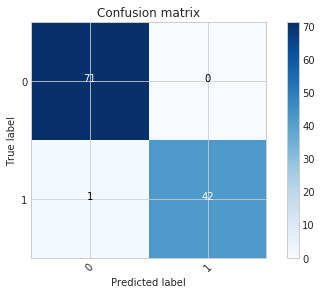

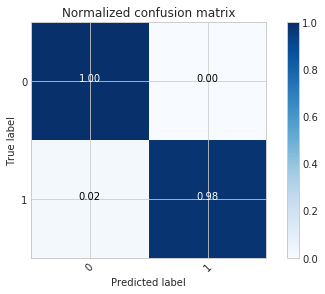

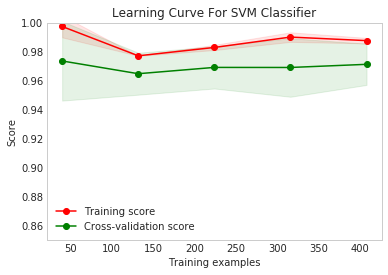

In [14]:
def selectParametersForSVM(a, b, c, d):
    model = SVC()
    parameters = {'C': [0.01, 0.1, 0.5, 1.0, 5.0, 10, 25, 50, 100],
                  'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
    accuracy_scorer = make_scorer(accuracy_score)
    grid_obj = GridSearchCV(model, parameters, scoring=accuracy_scorer)
    grid_obj = grid_obj.fit(a, b)
    model = grid_obj.best_estimator_
    model.fit(a, b)
    print('Selected Parameters for SVM:\n')
    print(model,"\n")
    kfold = model_selection.KFold(n_splits=10, random_state=7)
    accuracy = model_selection.cross_val_score(model, c, d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('Support Vector Machine - Training set accuracy: %s (%s)' % (mean, stdev))
    print('')
    prediction = model.predict(c)
    cnf_matrix = confusion_matrix(d, prediction)
    np.set_printoptions(precision=2)
    class_names = dict_characters 
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
    plot_learning_curve(model, 'Learning Curve For SVM Classifier', X_trainScaledPCA, Y_trainScaledPCA, (0.85,1), 10)
print("\nAfter Data Scaling:\n")
selectParametersForSVM(X_trainScaled, Y_trainScaled,  X_testScaled, Y_testScaled)


After PCA:

Selected Parameters for SVM:

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

Support Vector Machine - Training set accuracy: 0.931060606061 (0.0837763705177)

Confusion matrix, without normalization
[[63  2]
 [ 4 45]]
Normalized confusion matrix
[[ 0.97  0.03]
 [ 0.08  0.92]]


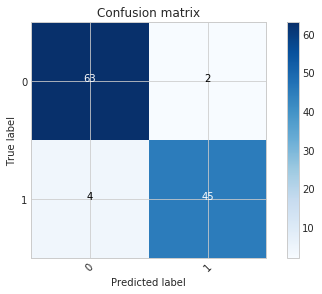

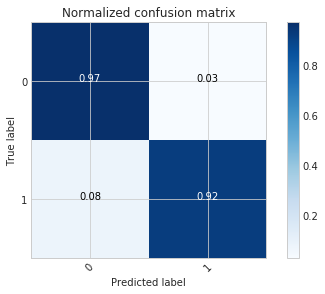

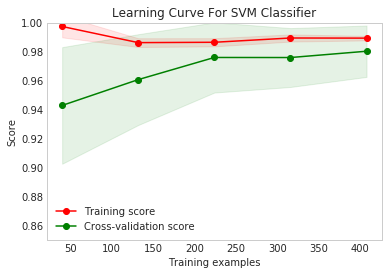

In [15]:
print("\nAfter PCA:\n")
selectParametersForSVM(X_trainScaledPCA, Y_trainScaledPCA,  X_testScaledPCA, Y_testScaledPCA)

Next I will try using neural networks in order to make these same predictions.

Before Data Scaling:

Selected Parameters for Multi-Layer Perceptron NN:

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

SKlearn Multi-Layer Perceptron - Training set accuracy: 0.937878787879 (0.0575757575758)

Confusion matrix, without normalization
[[73  2]
 [10 29]]
Normalized confusion matrix
[[ 0.97  0.03]
 [ 0.26  0.74]]


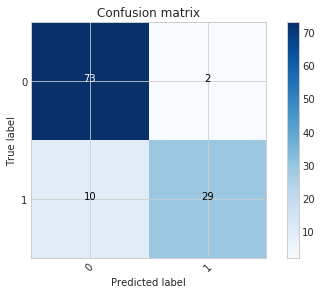

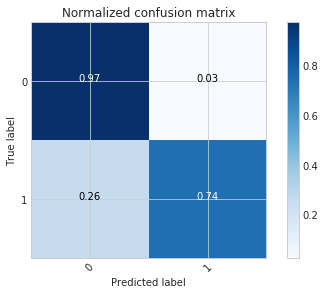

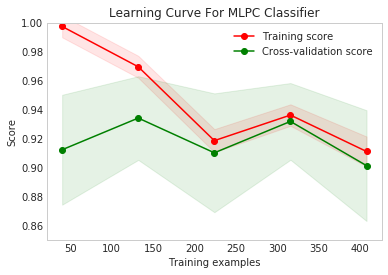

In [16]:
def selectParametersForMLPC(a, b, c, d):
    """http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    http://scikit-learn.org/stable/modules/grid_search.html#grid-search"""
    model = MLPC()
    parameters = {'verbose': [False],
                  'activation': ['logistic', 'relu'],
                  'max_iter': [1000, 2000], 'learning_rate': ['constant', 'adaptive']}
    accuracy_scorer = make_scorer(accuracy_score)
    grid_obj = GridSearchCV(model, parameters, scoring=accuracy_scorer)
    grid_obj = grid_obj.fit(a, b)
    model = grid_obj.best_estimator_
    model.fit(a, b)
    print('Selected Parameters for Multi-Layer Perceptron NN:\n')
    print(model)
    print('')
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c, d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('SKlearn Multi-Layer Perceptron - Training set accuracy: %s (%s)' % (mean, stdev))
    print('')
    prediction = model.predict(c)
    cnf_matrix = confusion_matrix(d, prediction)
    np.set_printoptions(precision=2)
    class_names = dict_characters 
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
    plot_learning_curve(model, 'Learning Curve For MLPC Classifier', a, b, (0.85,1), 10)
print("Before Data Scaling:\n")
selectParametersForMLPC(X_trainOriginal, Y_trainOriginal,  X_testOriginal, Y_testOriginal)

After Data Scaling:

Selected Parameters for Multi-Layer Perceptron NN:

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

SKlearn Multi-Layer Perceptron - Training set accuracy: 0.982575757576 (0.0348896331505)

Confusion matrix, without normalization
[[71  0]
 [ 2 41]]
Normalized confusion matrix
[[ 1.    0.  ]
 [ 0.05  0.95]]


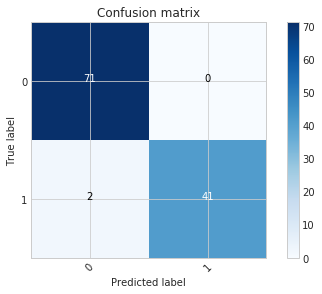

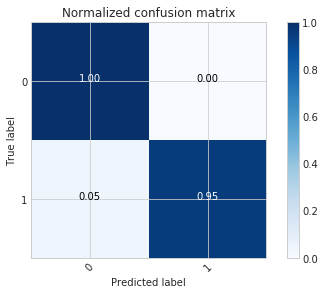

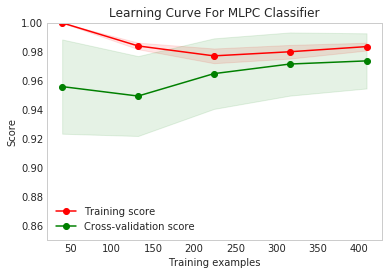

In [17]:
print("After Data Scaling:\n")
selectParametersForMLPC(X_trainScaled, Y_trainScaled,  X_testScaled, Y_testScaled)

After PCA:

Selected Parameters for Multi-Layer Perceptron NN:

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

SKlearn Multi-Layer Perceptron - Training set accuracy: 0.938636363636 (0.0702097408733)

Confusion matrix, without normalization
[[64  1]
 [ 4 45]]
Normalized confusion matrix
[[ 0.98  0.02]
 [ 0.08  0.92]]


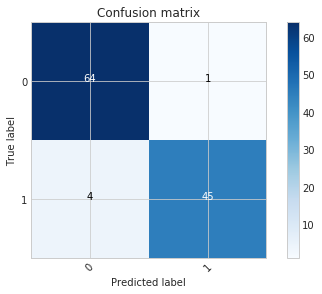

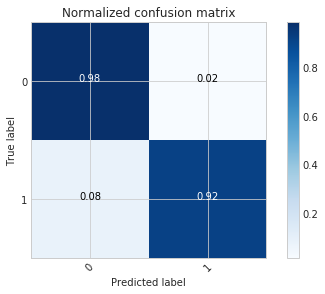

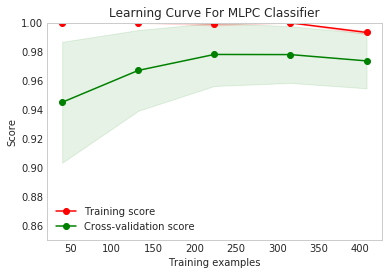

In [18]:
print("After PCA:\n")
selectParametersForMLPC(X_trainScaledPCA, Y_trainScaledPCA,  X_testScaledPCA, Y_testScaledPCA)

Next I will try building a custom neural network using the Keras library.  https://keras.io/models/sequential/
This is just to compare what we would do in Keras to what we would do in Sklearn,

In [19]:
def runSimpleKeras(a,b,c,d):
    """ Build and run Two different NNs using Keras"""
    #global kerasModelOne # eventually I should get rid of these global variables and use classes instead.  in this case i need these variables for the submission function.
    # kerasModelOne: simple network consisting of only two fully connected layers.
    Adagrad(lr=0.00001, epsilon=1e-08, decay=0.0)
    model = Sequential()
    model.add(Dense(input_dim=np.array(a).shape[1], units=128, kernel_initializer='normal', bias_initializer='zeros'))
    model.add(Activation('relu'))
    model.add(Dense(units=1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
    model.fit(np.array(a), np.array(b), epochs=10, verbose=2, validation_split=0.2)
    score = model.evaluate(np.array(c),np.array(d), verbose=0)
    print('\nLoss, Accuracy:\n', score)
    #kerasModelOne = model  
    #return kerasModelOne
print("Before Data Scaling:\n")
runSimpleKeras(X_trainOriginal,Y_trainOriginal,X_testOriginal,Y_testOriginal)
print("After Data Scaling:\n")
runSimpleKeras(X_trainScaled,Y_trainScaled,X_testScaled,Y_testScaled)
print("After PCA:\n")
runSimpleKeras(X_trainScaledPCA,Y_trainScaledPCA,X_testScaledPCA,Y_testScaledPCA)

Before Data Scaling:

Train on 364 samples, validate on 91 samples
Epoch 1/10
 - 0s - loss: 6.7537 - acc: 0.5797 - val_loss: 6.3764 - val_acc: 0.6044
Epoch 2/10
 - 0s - loss: 6.0664 - acc: 0.6236 - val_loss: 6.3764 - val_acc: 0.6044
Epoch 3/10
 - 0s - loss: 6.0664 - acc: 0.6236 - val_loss: 6.3764 - val_acc: 0.6044
Epoch 4/10
 - 0s - loss: 6.0664 - acc: 0.6236 - val_loss: 6.3764 - val_acc: 0.6044
Epoch 5/10
 - 0s - loss: 6.0664 - acc: 0.6236 - val_loss: 6.3764 - val_acc: 0.6044
Epoch 6/10
 - 0s - loss: 6.0664 - acc: 0.6236 - val_loss: 6.3764 - val_acc: 0.6044
Epoch 7/10
 - 0s - loss: 6.0664 - acc: 0.6236 - val_loss: 6.3764 - val_acc: 0.6044
Epoch 8/10
 - 0s - loss: 6.0664 - acc: 0.6236 - val_loss: 6.3764 - val_acc: 0.6044
Epoch 9/10
 - 0s - loss: 6.0664 - acc: 0.6236 - val_loss: 6.3764 - val_acc: 0.6044
Epoch 10/10
 - 0s - loss: 6.0664 - acc: 0.6236 - val_loss: 6.3764 - val_acc: 0.6044

Loss, Accuracy:
 [5.5140854768585736, 0.65789473893349626]
After Data Scaling:

Train on 364 samples,

Next I will try a voting classifier where we combine the best two models: SVM and MLPC.


After Data Scaling:

Ensemble Voting Classifier - Training set accuracy: 0.973484848485 (0.0405497687608)

Confusion matrix, without normalization
[[71  0]
 [ 1 42]]
Normalized confusion matrix
[[ 1.    0.  ]
 [ 0.02  0.98]]


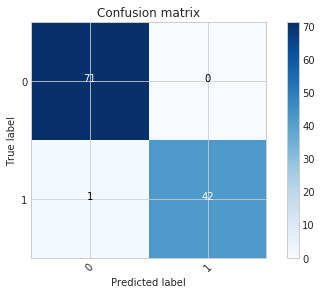

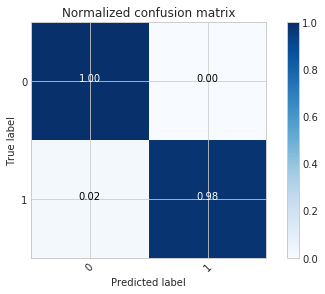

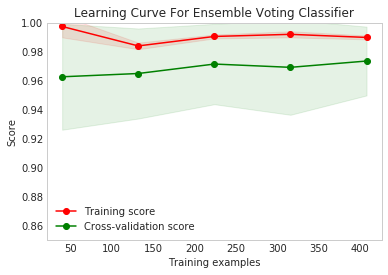

In [20]:
def runVotingClassifier(a,b,c,d):
    """http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
    http://scikit-learn.org/stable/modules/ensemble.html#voting-classifier"""
    #global votingC, mean, stdev # eventually I should get rid of these global variables and use classes instead.  in this case i need these variables for the submission function.
    votingC = VotingClassifier(estimators=[('SVM', SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)), ('MLPC', MLPC(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))], voting='hard')  
    votingC = votingC.fit(a,b)   
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(votingC, c,d, cv=kfold, scoring='accuracy')
    meanC = accuracy.mean() 
    stdevC = accuracy.std()
    print('Ensemble Voting Classifier - Training set accuracy: %s (%s)' % (meanC, stdevC))
    print('')
    #return votingC, meanC, stdevC
    prediction = votingC.predict(c)
    cnf_matrix = confusion_matrix(d, prediction)
    np.set_printoptions(precision=2)
    class_names = dict_characters 
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
    plot_learning_curve(votingC, 'Learning Curve For Ensemble Voting Classifier', X_trainScaledPCA, Y_trainScaledPCA, (0.85,1), 10)
print("\nAfter Data Scaling:\n")
runVotingClassifier(X_trainScaled, Y_trainScaled,  X_testScaled, Y_testScaled)


After PCA:

Ensemble Voting Classifier - Training set accuracy: 0.965909090909 (0.0418041807919)

Confusion matrix, without normalization
[[65  0]
 [ 4 45]]
Normalized confusion matrix
[[ 1.    0.  ]
 [ 0.08  0.92]]


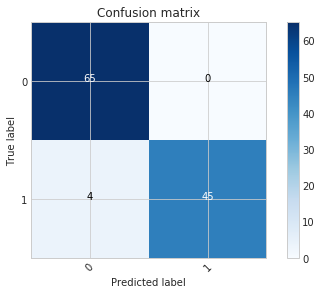

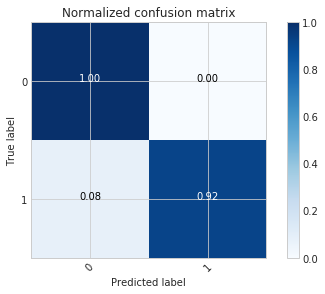

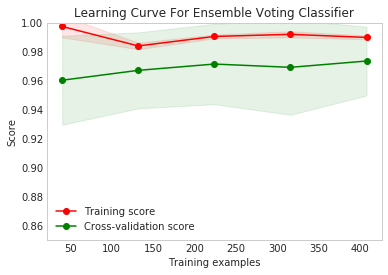

In [21]:
print("\nAfter PCA:\n")
runVotingClassifier(X_trainScaledPCA, Y_trainScaledPCA,  X_testScaledPCA, Y_testScaledPCA)

My apologies to the small percentage of patients with malignant tumors who were told that their tumors were benign.  Besides that, we were consistently accurate.  We had our best results when we used SVM, MLPC, or a VotingClassifier where we combined both SVM and MLPC.  Furthermore, we had the best results when we used data scaling and we did not see much of a difference when we used PCA.  In the future, tools like this can be used to save time, cut costs, and increase the accuracy of imaging-based diagnostic approaches in the healthcare industry.